In [1]:
import xarray as xr 
from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import glob

In [3]:
def plot_cartopy(ds,variable):
    list_vars = list(ds.data_vars)
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={"projection":ccrs.PlateCarree()})
    ds[variable].isel(time=0).plot(ax=ax,transform=ccrs.PlateCarree(),add_colorbar=False)
    ax.coastlines()
    return fig,ax 


file_paths = [
    '/Users/nalex2023/main/tropcyc/archive/atlantic_exps3/Datasets/ERA5_processed_40/RH_data40y.nc',
    '/Users/nalex2023/main/tropcyc/archive/atlantic_exps3/Datasets/ERA5_processed_40/shear_data40y.nc',
    '/Users/nalex2023/main/tropcyc/archive/atlantic_exps3/Datasets/ERA5_processed_40/spres_data_40y.nc',
    '/Users/nalex2023/main/tropcyc/archive/atlantic_exps3/Datasets/ERA5_processed_40/u_processed_5yr.nc',
    '/Users/nalex2023/main/tropcyc/archive/atlantic_exps3/Datasets/ERA5_processed_40/v_processed_5yr.nc',
    '/Users/nalex2023/main/tropcyc/archive/atlantic_exps3/Datasets/ERA5_processed_40/vort_data_40y.nc',
    '/Users/nalex2023/main/tropcyc/archive/atlantic_exps3/Datasets/ERA5_processed_40/sst_data_40y.nc'
]



In [4]:
test = xr.open_dataset('/Users/nalex2023/main/tropcyc/archive/atlantic_exps3/Datasets/ERA5_processed_40/v_processed_5yr.nc')

test

<xarray.Dataset>
Dimensions:    (longitude: 341, latitude: 193, level: 6, time: 17536)
Coordinates:
  * longitude  (longitude) float32 -83.0 -82.75 -82.5 -82.25 ... 1.5 1.75 2.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... -4.5 -4.75 -5.0
  * level      (level) int32 200 250 300 775 800 925
  * time       (time) datetime64[ns] 2000-01-01 ... 2005-12-31T21:00:00
Data variables:
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-31 06:13:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [35]:
def preprocess(ds):
    ds_time_sel = ds.sel(time=slice('2000','2005'))
    if 'expver' in ds_time_sel:
        ds_time_sel = ds_time_sel.drop_vars('expver',errors='ignore')
    if 'level' in ds_time_sel:
        ds_time_sel = ds_time_sel.sel(level=1000,method='nearest')
    #ds_time_6h = ds_time_sel.resample(time='6h').mean() # proble with this one

    return ds_time_sel

# importance of join
ds_all = xr.open_mfdataset(file_paths,preprocess=preprocess,chunks={'time':10000,'latitude':100,'longitude':100},combine_attrs='drop',join='inner')

ds_all['rand_arr'] = xr.DataArray(data=np.random.rand(len(ds_all.time),len(ds_all.latitude),len(ds_all.longitude)),dims=['time','latitude','longitude'],coords={'time':ds_all.time,'latitude':ds_all.latitude,'longitude':ds_all.longitude})

In [36]:
sst_null_points = ds_all.sst.isnull()
ds_all['sst'] = ds_all['sst'].fillna(ds_all['rand_arr'])

ds_all.drop_vars('rand_arr',errors='ignore')

<xarray.Dataset>
Dimensions:      (longitude: 79, latitude: 42, time: 8784)
Coordinates:
  * longitude    (longitude) float32 -83.0 -82.0 -81.0 -80.0 ... -7.0 -6.0 -5.0
  * latitude     (latitude) float32 43.0 42.0 41.0 40.0 39.0 ... 5.0 4.0 3.0 2.0
  * time         (time) datetime64[ns] 2000-06-01 ... 2005-11-30T21:00:00
    level        int32 925
Data variables:
    r            (time, latitude, longitude) float32 dask.array<chunksize=(7760, 42, 79), meta=np.ndarray>
    sp           (time, latitude, longitude) float32 dask.array<chunksize=(7760, 42, 79), meta=np.ndarray>
    speed_shear  (time, latitude, longitude) float32 dask.array<chunksize=(7760, 42, 79), meta=np.ndarray>
    sst          (time, latitude, longitude) float64 dask.array<chunksize=(7760, 42, 79), meta=np.ndarray>
    u            (time, latitude, longitude) float32 dask.array<chunksize=(8784, 42, 79), meta=np.ndarray>
    v            (time, latitude, longitude) float32 dask.array<chunksize=(8784, 42, 79), meta=np.ndarray>
    vo           (time, latitude, longitude) float32 dask.array<chunksize=(8372, 42, 79), meta=np.ndarray>

In [38]:
ds_all_re = ds_all.resample(time='6h').mean()

/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [39]:
ds_all_re

<xarray.Dataset>
Dimensions:      (longitude: 79, latitude: 42, time: 8036)
Coordinates:
  * longitude    (longitude) float32 -83.0 -82.0 -81.0 -80.0 ... -7.0 -6.0 -5.0
  * latitude     (latitude) float32 43.0 42.0 41.0 40.0 39.0 ... 5.0 4.0 3.0 2.0
  * time         (time) datetime64[ns] 2000-06-01 ... 2005-11-30T18:00:00
    level        int32 925
Data variables:
    r            (time, latitude, longitude) float32 dask.array<chunksize=(1, 42, 79), meta=np.ndarray>
    sp           (time, latitude, longitude) float32 dask.array<chunksize=(1, 42, 79), meta=np.ndarray>
    speed_shear  (time, latitude, longitude) float32 dask.array<chunksize=(1, 42, 79), meta=np.ndarray>
    sst          (time, latitude, longitude) float64 dask.array<chunksize=(1, 42, 79), meta=np.ndarray>
    u            (time, latitude, longitude) float32 dask.array<chunksize=(1, 42, 79), meta=np.ndarray>
    v            (time, latitude, longitude) float32 dask.array<chunksize=(1, 42, 79), meta=np.ndarray>
    vo           (time, latitude, longitude) float32 dask.array<chunksize=(1, 42, 79), meta=np.ndarray>
    rand_arr     (time, latitude, longitude) float64 0.4778 0.7102 ... 0.2888

In [40]:
ds_all_re.to_netcdf('/Users/nalex2023/main/tropcyc/archive/atlantic_exps3/Datasets/ERA5_processed_40/final_proc_5yr_6h.nc')

In [41]:
input_dsets = xr.open_dataset('/Users/nalex2023/main/tropcyc/archive/atlantic_exps3/Datasets/ERA5_processed_40/final_proc_5yr_6h.nc')

In [42]:
# calculating coriolis parameter 
import numpy as np

cor_parms =  2 * 7.29 * 1e-5 * np.sin(np.radians(input_dsets['latitude']))

input_dsets['cor_params'] = xr.DataArray(cor_parms,
                                            name='cor_params'
                                            ).broadcast_like(input_dsets['r'])



In [44]:

input_dsets

<xarray.Dataset>
Dimensions:      (longitude: 79, latitude: 42, time: 8036)
Coordinates:
  * longitude    (longitude) float32 -83.0 -82.0 -81.0 -80.0 ... -7.0 -6.0 -5.0
  * latitude     (latitude) float32 43.0 42.0 41.0 40.0 39.0 ... 5.0 4.0 3.0 2.0
  * time         (time) datetime64[ns] 2000-06-01 ... 2005-11-30T18:00:00
    level        int32 ...
Data variables:
    r            (time, latitude, longitude) float32 ...
    sp           (time, latitude, longitude) float32 ...
    speed_shear  (time, latitude, longitude) float32 ...
    sst          (time, latitude, longitude) float64 ...
    u            (time, latitude, longitude) float32 ...
    v            (time, latitude, longitude) float32 ...
    vo           (time, latitude, longitude) float32 ...
    rand_arr     (time, latitude, longitude) float64 ...
    cor_params   (time, latitude, longitude) float32 9.944e-05 ... 5.088e-06

In [124]:
ib_data = '/Users/nalex2023/main/tropcyc/archive/atlantic_exps/Datasets/ibtracs.NA.list.v04r00.csv'

from global_land_mask import globe


def process_ibrack(ib_loc, periods=[2000,2005]):
    read_ib_data = pd.read_csv(ib_loc,keep_default_na=False)
    units = read_ib_data.iloc[0,:]
    ib_original_dft = read_ib_data.iloc[1:,:]
    ib_original_dft['datetime'] = pd.to_datetime(ib_original_dft['ISO_TIME'],format='%Y-%m-%d %H:%M:%S')
    year_mask = (ib_original_dft['datetime'] > f'{periods[0]}-1-1') & (ib_original_dft['datetime'] <= f'{periods[1]}-11-30')
    period_new = ib_original_dft[year_mask][ib_original_dft['BASIN'] == 'NA']
    def only_na_basin(df):
        lon_wise = df.sort_values(by='datetime')
        if lon_wise['LON'].iloc[0] > -55:
            return df
        else:
            return None
        
    only_neatlantic = period_new.groupby('SID').apply(only_na_basin).reset_index(drop=True)
    counts = only_neatlantic.groupby('SID').count().iloc[:,0]
    counts_12 = counts[counts > 12].index
    persist_storms = period_new[period_new['SID'].isin(counts_12)]
    persist_storms['month']= persist_storms['datetime'].dt.month
    from global_land_mask import globe
    # mask out land points
    def mask_lands(df):
        ordered_df = df.sort_values(by='datetime')
        lat = ordered_df['LAT']
        lon = ordered_df['LON']
        ocean_mask = pd.Series(globe.is_ocean(lat=lat,lon=lon))
        idx_false = ocean_mask.idxmin()
        if idx_false == 0:
            return df
        else:
            land_mask = ocean_mask.iloc[:idx_false]
            final_masked = ordered_df.iloc[:idx_false,:]
            return final_masked
    # filter extratropical parts of the storm tracks
    def filter_ET(df):
        ordered_df = df.sort_values(by='datetime')
        lat_filter = ordered_df['LAT'] <= 30
        filter_df = ordered_df[lat_filter]
        return filter_df
    exclude_et = persist_storms.groupby('SID').apply(filter_ET).reset_index(drop=True)

    final_dft = exclude_et.groupby('SID').apply(mask_lands).reset_index(drop=True)

    return final_dft

    


ib_data_processed = process_ibrack(ib_data,periods=[2000,2005])
ib_data_processed['LAT'] = ib_data_processed['LAT'].astype(float)
ib_data_processed['LON'] = ib_data_processed['LON'].astype(float)
ib_data_processed['USA_WIND'] = ib_data_processed['USA_WIND'].astype(float)
ib_data_processed['datetime'] = pd.to_datetime(ib_data_processed['datetime'],format='%Y-%m-%d %H:%M:%S')
ib_data_processed['SID'] = ib_data_processed['SID'].astype(str)

ib_data_processed['id'] = ib_data_processed['SID'].astype('category')
ib_data_processed['id'] = ib_data_processed['id'].cat.codes
req_cols = ['datetime','LAT','LON','USA_WIND','id']

# groupby datetime 6h 
ib_data_processed['datetime'] = ib_data_processed['datetime'].dt.floor('6h')

ib_data_processed_6h = ib_data_processed[req_cols].groupby('datetime').mean().reset_index()

# copy the SID based on the id

ib_data_processed_6h['SID'] = ib_data_processed.groupby('datetime')['SID'].first().values


/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_1292/624549893.py:7: DtypeWarning: Columns (1,2,8,9,14,19,20,23,24,161,162) have mixed types. Specify dtype option on import or set low_memory=False.
  read_ib_data = pd.read_csv(ib_loc,keep_default_na=False)
/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_1292/624549893.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ib_original_dft['datetime'] = pd.to_datetime(ib_original_dft['ISO_TIME'],format='%Y-%m-%d %H:%M:%S')
/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_1292/624549893.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  period_new = ib_original_dft[year_mask][ib_original_dft['BASIN'] == 'NA']
/var/folders/bt/kswp83jx5mj

In [125]:
ib_data_processed_6h

,datetime,LAT,LON,USA_WIND,id,SID
0,2000-06-23 00:00:00,9.515070,-20.08375,26.0,0.0,2000175N09340
1,2000-06-23 06:00:00,9.667420,-21.37375,30.0,0.0,2000175N09340
2,2000-06-23 12:00:00,9.990000,-23.07115,30.0,0.0,2000175N09340
3,2000-06-23 18:00:00,10.193600,-24.93630,30.0,0.0,2000175N09340
4,2000-06-24 00:00:00,10.046155,-26.60755,30.0,0.0,2000175N09340
...,...,...,...,...,...,...
968,2005-11-27 06:00:00,25.263700,-33.48280,48.5,40.0,2005324N27312
969,2005-11-27 12:00:00,27.140450,-31.41080,60.0,40.0,2005324N27312
970,2005-11-27 18:00:00,28.529500,-29.32495,60.0,40.0,2005324N27312
971,2005-11-28 00:00:00,29.317800,-26.85515,60.0,40.0,2005324N27312


(<Figure size 2000x1000 with 1 Axes>, <GeoAxes: >)

/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


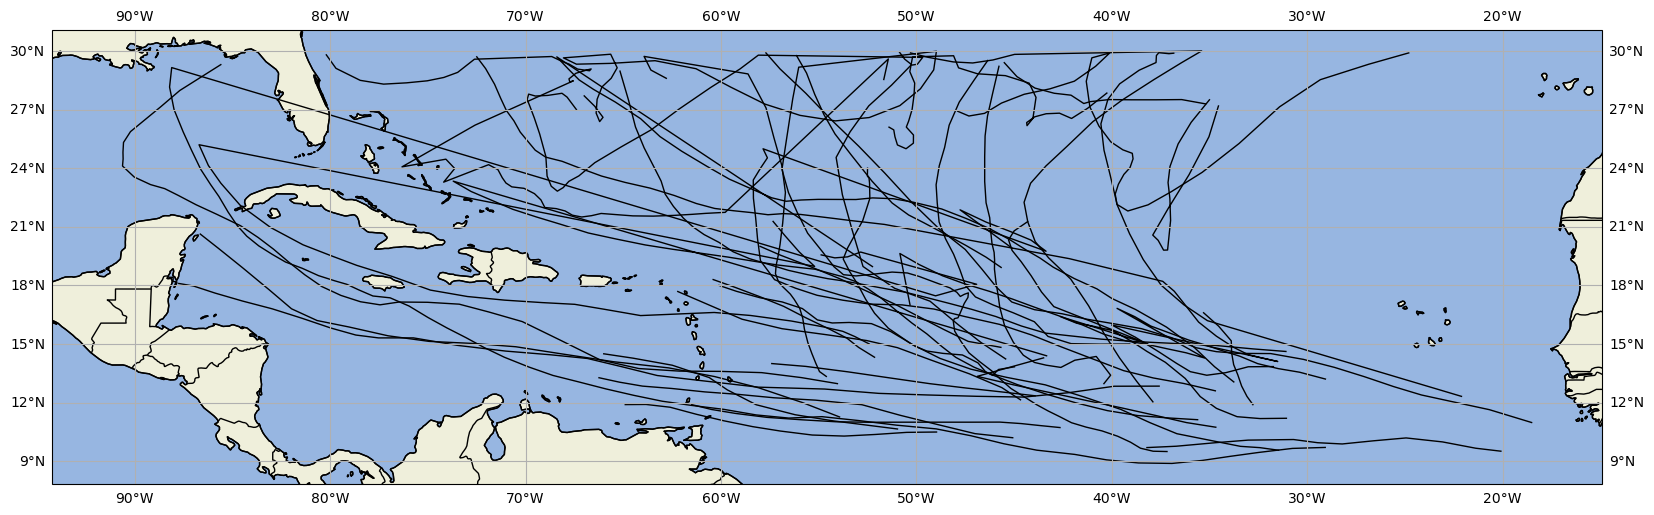

In [126]:
import cartopy.feature as cfeature

def plot_tracks(filtered_ib):
    filtered_ib['datetime'] = pd.to_datetime(filtered_ib['datetime'])

    events = filtered_ib.groupby('SID')
    
    fig,ax = plt.subplots(figsize=(20,10),subplot_kw={"projection": ccrs.PlateCarree()})
    
    ax.add_feature(cfeature.COASTLINE)

    ax.add_feature(cfeature.BORDERS)


    ax.coastlines()
    
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    
    for event_num , event in events:
        roll_events = event.set_index('datetime')[['LON','LAT']].rolling(window=24).mean()
        lon = event['LON'].values
        lat = event['LAT'].values
        ax.plot(lon,lat,transform=ccrs.PlateCarree(),linewidth=1,color='black')
    return fig,ax

plot_tracks(ib_data_processed_6h)

In [127]:
ib_data_processed_6h

,datetime,LAT,LON,USA_WIND,id,SID
0,2000-06-23 00:00:00,9.515070,-20.08375,26.0,0.0,2000175N09340
1,2000-06-23 06:00:00,9.667420,-21.37375,30.0,0.0,2000175N09340
2,2000-06-23 12:00:00,9.990000,-23.07115,30.0,0.0,2000175N09340
3,2000-06-23 18:00:00,10.193600,-24.93630,30.0,0.0,2000175N09340
4,2000-06-24 00:00:00,10.046155,-26.60755,30.0,0.0,2000175N09340
...,...,...,...,...,...,...
968,2005-11-27 06:00:00,25.263700,-33.48280,48.5,40.0,2005324N27312
969,2005-11-27 12:00:00,27.140450,-31.41080,60.0,40.0,2005324N27312
970,2005-11-27 18:00:00,28.529500,-29.32495,60.0,40.0,2005324N27312
971,2005-11-28 00:00:00,29.317800,-26.85515,60.0,40.0,2005324N27312


In [128]:
input_dsets.sel(time='2002-09-30')

<xarray.Dataset>
Dimensions:      (longitude: 79, latitude: 42, time: 4)
Coordinates:
  * longitude    (longitude) float32 -83.0 -82.0 -81.0 -80.0 ... -7.0 -6.0 -5.0
  * latitude     (latitude) float32 43.0 42.0 41.0 40.0 39.0 ... 5.0 4.0 3.0 2.0
  * time         (time) datetime64[ns] 2002-09-30 ... 2002-09-30T18:00:00
    level        int32 ...
Data variables:
    r            (time, latitude, longitude) float32 ...
    sp           (time, latitude, longitude) float32 ...
    speed_shear  (time, latitude, longitude) float32 ...
    sst          (time, latitude, longitude) float64 ...
    u            (time, latitude, longitude) float32 ...
    v            (time, latitude, longitude) float32 ...
    vo           (time, latitude, longitude) float32 ...
    rand_arr     (time, latitude, longitude) float64 ...
    cor_params   (time, latitude, longitude) float32 9.944e-05 ... 5.088e-06

In [158]:
# iterate through rows iterrows

final_data = []
max_len = ib_data_processed_6h.groupby('SID').size().max()  # assuming max length is 3 hours per storm
for sid,group in ib_data_processed_6h.groupby('SID'):
    events_data = []
    for i,row in group.iterrows():
        lat = int(row['LAT'])
        lon = int(row['LON'])
        time = row['datetime']
        latmin = lat - 2
        latmax = lat + 2
        lonmin = lon - 2
        lonmax = lon + 2
        sel_data = input_dsets.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), time=time)
        
            
        final_xr = sel_data.rename({'latitude': 'y', 'longitude': 'x'})
        final_xr['x'] = np.arange(0,final_xr.sizes['x'])
        final_xr['y'] = np.arange(0,final_xr.sizes['y'])
        #final_xr = final_xr.map(lambda x: np.zeros(x.shape) if x.isnull().any() else x)
        # fill NaN values with zeros along the x and y dimensions
        for jj in final_xr.data_vars:
            final_xr[jj].fillna(0)  # Fill NaN values
        final_xr['target'] = row['USA_WIND']    
        events_data.append(final_xr)
    final_event = xr.concat(events_data,dim='time')
    if len(final_event.time) <= max_len:
        new_time = pd.date_range(start=final_event['time'].min().values, periods=max_len ,freq='6h')
        padded_data = final_event.reindex(time=new_time, fill_value=0.0)
    else:
        padded_data = final_event
    
    lead_time = np.arange(0,max_len*6 ,6)
    padded_data['lead'] = ('time', lead_time)
    padded_data = padded_data.assign_coords({'lead': padded_data['lead'].astype(int)})
    # swap time and lead dimensions
    padded_data = padded_data.swap_dims({'time': 'lead'})
    padded_data['SID'] = sid 
    # convert the time dimension to a variable
    final_data.append(padded_data)


final_input_padded = xr.concat(final_data, dim='SID')
final_input_padded




/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/xarr

<xarray.Dataset>
Dimensions:      (x: 5, y: 5, SID: 40, lead: 71)
Coordinates:
  * x            (x) int64 0 1 2 3 4
  * y            (y) int64 0 1 2 3 4
    time         (SID, lead) datetime64[ns] 2000-06-23 ... 2005-12-07
    level        int32 925
  * lead         (lead) int64 0 6 12 18 24 30 36 ... 384 390 396 402 408 414 420
  * SID          (SID) <U13 '2000175N09340' '2000217N11342' ... '2005324N27312'
Data variables:
    r            (SID, lead, y, x) float64 90.72 90.94 86.49 ... 0.0 0.0 0.0
    sp           (SID, lead, y, x) float64 1.014e+05 1.014e+05 ... 0.0 0.0
    speed_shear  (SID, lead, y, x) float64 8.288 6.2 3.47 1.145 ... 0.0 0.0 0.0
    sst          (SID, lead, y, x) float64 299.8 299.8 300.5 ... 0.0 0.0 0.0
    u            (SID, lead, y, x) float64 -3.772 -6.573 -8.691 ... 0.0 0.0 0.0
    v            (SID, lead, y, x) float64 -5.732 -7.045 -5.061 ... 0.0 0.0 0.0
    vo           (SID, lead, y, x) float64 4.975e-07 9.506e-06 ... 0.0 0.0
    rand_arr     (SID, lead, y, x) float64 0.3126 0.2106 0.5885 ... 0.0 0.0 0.0
    cor_params   (SID, lead, y, x) float64 2.782e-05 2.782e-05 ... 0.0 0.0
    target       (SID, lead) float64 26.0 30.0 30.0 30.0 ... 0.0 0.0 0.0 0.0

In [145]:
import dask
import numpy as np
import xarray as xr

def process_row(row, input_dsets):
    lat = int(row['LAT'])
    lon = int(row['LON'])
    time = row['datetime']
    latmin = lat - 5
    latmax = lat + 5
    lonmin = lon - 5
    lonmax = lon + 5

    try:
        # Select the data for the given lat/lon/time
        sel_data = input_dsets.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), time=time)
    
    except KeyError:
        # If data is not found, return None (will be filtered out later)
        print(f"Data not found for SID: {row['SID']} at time {time} with lat {lat} and lon {lon}")
        return None

    # Add SID and wind speed as new variables
    sel_data['SID'] = row['SID']
    wind_speed = row['USA_WIND']

    # Rename dimensions and set coordinate ranges
    final_xr = sel_data.rename({'latitude': 'y', 'longitude': 'x'})
    final_xr['x'] = np.arange(0, len(final_xr['x']), 1)
    final_xr['y'] = np.arange(0, len(final_xr['y']), 1)
    final_xr = final_xr.fillna(0)  # Fill NaN values with zeros
    final_xr['target'] = wind_speed

    return final_xr

# Wrap your row processing in dask.delayed
delayed_results = []
for index, row in ib_data_processed.iterrows():
    delayed_result = dask.delayed(process_row)(row, input_dsets)
    delayed_results.append(delayed_result)

# Compute in parallel and filter out None results
final_data = dask.compute(*delayed_results)
final_data = [ds for ds in final_data if ds is not None]

# Concatenate along 'time' dimension
final_data_xr = xr.concat(final_data, dim='time')

/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [148]:
final_input_padded.to_netcdf('/Users/nalex2023/main/tropcyc/pythia_cookbook/datasets/input_predictands.nc')

In [301]:
def convert_to_numpy(dset):
    nump_values = dset.to_array().values
    df_data = None
              
    return df_data,nump_values


df, nump_values = convert_to_numpy(final_data)


In [149]:
input_final = xr.open_dataset('/Users/nalex2023/main/tropcyc/pythia_cookbook/datasets/input_predictands.nc')

In [150]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [125]:
# find the data with NaN values
nan_mask = np.isnan(input_final['r'])
# nan coords 

nan_coords = np.where(nan_mask)
nan_coords_df = pd.DataFrame({'time': nan_coords[0], 'y': nan_coords[1], 'x': nan_coords[2], 'SID': input_final['SID'].values[nan_coords[0]]})

nan_coords_df

,time,y,x,SID
0,0,0,0,2000175N09340
1,0,0,0,2000175N09340
2,0,0,0,2000175N09340
3,0,0,0,2000175N09340
4,0,0,0,2000175N09340
...,...,...,...,...
51320,41,0,4,2005333N32311
51321,41,0,4,2005333N32311
51322,41,0,4,2005333N32311
51323,41,0,4,2005333N32311


In [163]:
final_padded_filled = final_input_padded.fillna(0)  # Fill NaN values with zeros

In [164]:
input_final = final_padded_filled

In [165]:
x_data = input_final[['u', 'v', 'vo', 'speed_shear', 'sp', 'r', 'cor_params']].to_array().values

sid_groups = input_final['SID'].to_dataframe()


x_data_ordered = x_data.transpose(1,2,3,4,0)

y_data = input_final['target'].values


# expand dimensions to match the input shape
y_data = np.expand_dims(y_data, axis=-1)

y_data.shape

(40, 71, 1)

In [166]:
# scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train, x_test, y_train, y_test = train_test_split(x_data_ordered, y_data, test_size=0.2, random_state=1)

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)



In [167]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l1_l2
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
# import timedistributed as tfd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Reshape
from tensorflow.keras.layers import Masking
# import adam
from tensorflow.keras.optimizers import Adam

In [168]:
from keras import layers

# how to mask the data using tf cast not loss 



In [169]:
def masked_mse(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)
    squared_error = tf.square(y_true - y_pred)
    masked_loss = tf.reduce_sum(squared_error * mask) / (tf.reduce_sum(mask) + 1e-6)
    return masked_loss

model = Sequential()
model.add(TimeDistributed(
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    input_shape=(140, 5, 5, 7)
))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, return_sequences=True))  # <--- important!
model.add(TimeDistributed(Dense(1)))

model.summary()

/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 140, 5, 5, 16)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 140, 400)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 140, 64)        │       119,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 140, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

In [170]:
model.compile(optimizer='adam', metrics=['mae'] , loss=masked_mse)

In [171]:
model.fit(x_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 4396.9346 - mae: 18.0562 - val_loss: 1668.1199 - val_mae: 13.8166
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 4295.5200 - mae: 17.8974 - val_loss: 1610.2882 - val_mae: 13.9258
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 4209.5449 - mae: 18.0482 - val_loss: 1558.2344 - val_mae: 14.0564
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 4136.2085 - mae: 18.2207 - val_loss: 1510.1476 - val_mae: 14.2045
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 4067.7703 - mae: 18.4074 - val_loss: 1465.3396 - val_mae: 14.3660
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 4001.9722 - mae: 18.6036 - val_loss: 1423.2279 - val_mae: 14.5323
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 3938.4600 - mae: 18.8030 - val_loss: 1383.2859 - val_mae: 14.6886
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 3877.8569 - mae: 18.9932 - val_loss: 1345.6063 - val_mae: 14.8343
Epoch 9/10
1/1

In [174]:
predict_x = model.predict(x_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


ValueError: non-broadcastable output operand with shape (568,1) doesn't match the broadcast shape (568,7)